# Image Preprocessing

The preprocessing we are going to apply to the images will de based on the work by Koushik Sivarama Krishnan et al.

Krishnan, K. S., Nikesh, P. J. J., Logeshwaran, M., Senthilkumar, G., & Elangovan, D. (2023, April 26). Automated classification of stroke blood clot origin using whole-slide digital pathology images. arXiv.org. Retrieved May 5, 2023, from https://arxiv.org/abs/2304.13775


From the .tif images we create patches using openslide python´s library. So the purpose of this notebook is to cover these steps of how to do it and finally get some tiles from the native resolution .tif image.
The first thing will we to install openslide library. You can try to install it directly from anaconda command prompt or via pip install.

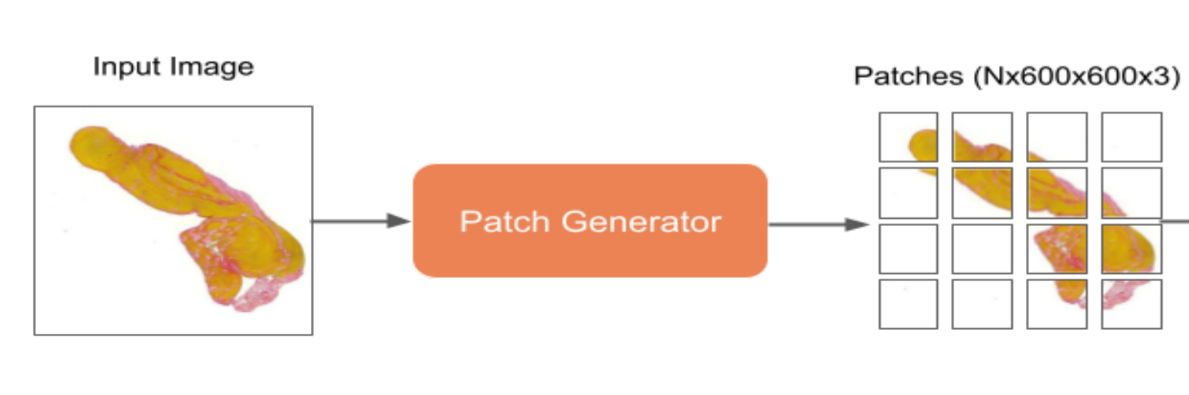

In order to install openslide library I would recommend to see @DigitalSreeni youtube tutorial: https://www.youtube.com/watch?v=QntLBvUZR5c

He explains in detail how to install and work with this library:)

In [1]:
pip install openslide-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
for p in sys.path:
    print(p)

C:\Users\pedro\Clase_Redes_Neuronales_2023
C:\Users\pedro\anaconda3\python39.zip
C:\Users\pedro\anaconda3\DLLs
C:\Users\pedro\anaconda3\lib
C:\Users\pedro\anaconda3

C:\Users\pedro\anaconda3\lib\site-packages
C:\Users\pedro\anaconda3\lib\site-packages\win32
C:\Users\pedro\anaconda3\lib\site-packages\win32\lib
C:\Users\pedro\anaconda3\lib\site-packages\Pythonwin


In [1]:
from openslide import open_slide
import os
import openslide
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [5]:
slide = open_slide("00c058_0.tif")

In [57]:
slide.properties

<_PropertyMap {'openslide.level-count': '1', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '61801', 'openslide.level[0].tile-height': '128', 'openslide.level[0].tile-width': '128', 'openslide.level[0].width': '15255', 'openslide.vendor': 'generic-tiff', 'tiff.ResolutionUnit': 'centimeter', 'tiff.XResolution': '10', 'tiff.YResolution': '10'}>

In [58]:
slide.dimensions

(15255, 61801)

In [55]:
slide_600 = slide.get_thumbnail(size=(600,600))
slide_600.show()

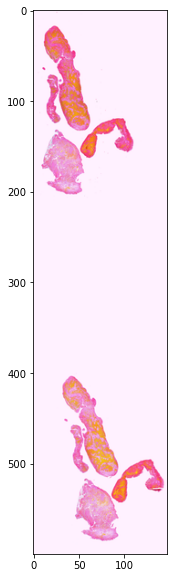

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(slide_600));

In [16]:
slide.level_dimensions

((15255, 61801),)

# Creating Image Patches

Now we use the DeepZoomGenerator to create the image patches. We not only get the patches but solve the memory issue by saving the tiles/patches as png format.

In [37]:
from openslide.deepzoom import DeepZoomGenerator

In [38]:
tiles = DeepZoomGenerator(slide, tile_size=600, overlap=0, limit_bounds=False)

In [39]:
tiles.level_count

17

In [40]:
tiles.level_dimensions

((1, 1),
 (1, 2),
 (1, 4),
 (2, 8),
 (4, 16),
 (8, 31),
 (15, 61),
 (30, 121),
 (60, 242),
 (120, 483),
 (239, 966),
 (477, 1932),
 (954, 3863),
 (1907, 7726),
 (3814, 15451),
 (7628, 30901),
 (15255, 61801))

In [41]:
tiles.tile_count

3644

In [42]:
tiles.get_tile_dimensions(11, (0,0))

(477, 600)

In [43]:
tiles.level_tiles[16]

(26, 104)

In [44]:
single_tile = tiles.get_tile(16, (15,25))

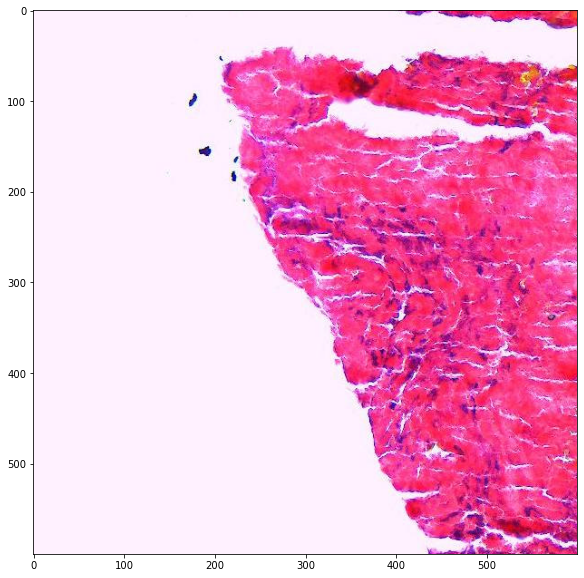

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(single_tile));

In [46]:
cols, rows = tiles.level_tiles[16]

In [47]:
cols, rows

(26, 104)

In [51]:
import os
tile_dir = "Image_patches/"
for row in range(rows):
    for col in range(cols):
        tile_name = os.path.join(tile_dir, '%d_%d' % (col, row))
        print("Now saving tile with title: ", tile_name)
        temp_tile = tiles.get_tile(16, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        plt.imsave(tile_name + ".png", temp_tile_np)

Now saving tile with title:  Image_patches/0_0
Now saving tile with title:  Image_patches/1_0
Now saving tile with title:  Image_patches/2_0
Now saving tile with title:  Image_patches/3_0
Now saving tile with title:  Image_patches/4_0
Now saving tile with title:  Image_patches/5_0
Now saving tile with title:  Image_patches/6_0
Now saving tile with title:  Image_patches/7_0
Now saving tile with title:  Image_patches/8_0
Now saving tile with title:  Image_patches/9_0
Now saving tile with title:  Image_patches/10_0
Now saving tile with title:  Image_patches/11_0
Now saving tile with title:  Image_patches/12_0
Now saving tile with title:  Image_patches/13_0
Now saving tile with title:  Image_patches/14_0
Now saving tile with title:  Image_patches/15_0
Now saving tile with title:  Image_patches/16_0
Now saving tile with title:  Image_patches/17_0
Now saving tile with title:  Image_patches/18_0
Now saving tile with title:  Image_patches/19_0
Now saving tile with title:  Image_patches/20_0
No

# Managing blank images and using H&E Normalization

The next step is to handle images that don´t represent or give us relevant pixel information about the content, let call these images blank images and use a proposed worflow to stablish a selection criteria based on the H&E normalization

In [26]:
def norm_HnE(img, Io=240, alpha=1, beta=0.15):

    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])

    maxCRef = np.array([1.9705, 1.0308])

    h, w, c = img.shape

    img = img.reshape((-1,3))

    
    OD = -np.log10((img.astype(float)+1)/Io) 

    ODhat = OD[~np.any(OD < beta, axis=1)] 

    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
   
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product

    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)

    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T

    Y = np.reshape(OD, (-1, 3)).T

    C = np.linalg.lstsq(HE,Y, rcond=None)[0]

    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])

    
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  

    
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return (Inorm, H, E)

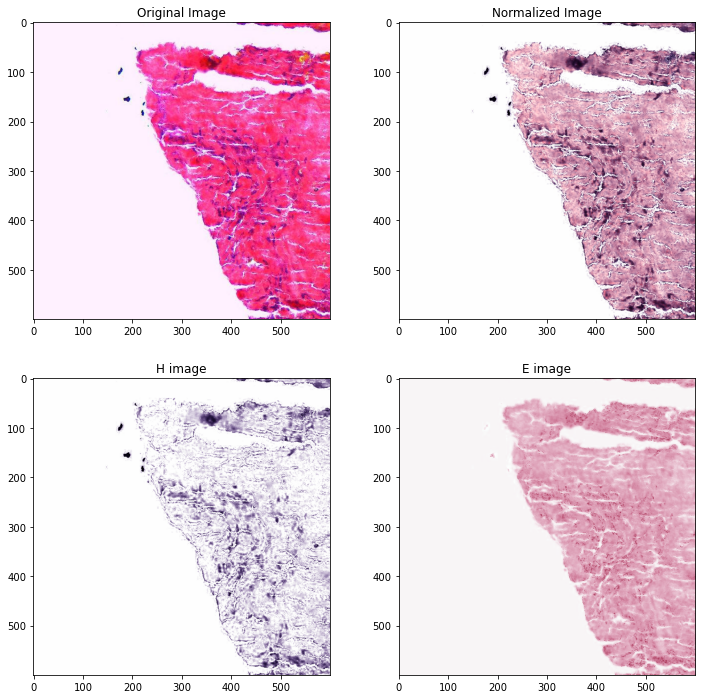

In [27]:
norm_img, H_img, E_img = norm_HnE(np.array(single_tile), Io=250, alpha=1, beta=0.15)

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Original Image')
plt.imshow(np.array(single_tile))
plt.subplot(222)
plt.title('Normalized Image')
plt.imshow(norm_img)
plt.subplot(223)
plt.title('H image')
plt.imshow(H_img)
plt.subplot(224)
plt.title('E image')
plt.imshow(E_img)
plt.show()

We can observe that the original image is really capturing well the information we need. Making the assumption that a Conv net model will look to pixel intensities in order to make the prediction, the normalized images may not imrpove the model performance. 
Again credit to @DigitalSreeni for this transalet from MATLAB to Python function.

In [30]:
import tifffile as tiff

In [33]:
def find_mean_std_pixel_value(img_list):
    
    avg_pixel_value = []
    stddev_pixel_value= []
    for file in img_list:
        image = cv2.imread(file)
        avg = image.mean()
        std = image.std()
        avg_pixel_value.append(avg)
        stddev_pixel_value.append(std)
        
    avg_pixel_value = np.array(avg_pixel_value)  
    stddev_pixel_value=np.array(stddev_pixel_value)
        
    print("Average pixel value for all images is:", avg_pixel_value.mean())
    print("Average std dev of pixel value for all images is:", stddev_pixel_value.mean())
    
    return(avg_pixel_value, stddev_pixel_value)

In [34]:
find_mean_std_pixel_value(["Image_patches/0_0.png"])

Average pixel value for all images is: 250.33333333333334
Average std dev of pixel value for all images is: 6.599663291074438


(array([250.33333333]), array([6.59966329]))

In [35]:
find_mean_std_pixel_value(["Image_patches/11_91.png"])

Average pixel value for all images is: 194.94522777777777
Average std dev of pixel value for all images is: 56.189805158118986


(array([194.94522778]), array([56.18980516]))

In [36]:
find_mean_std_pixel_value(["Image_patches/11_92.png"])

Average pixel value for all images is: 203.27041944444446
Average std dev of pixel value for all images is: 55.69152690216382


(array([203.27041944]), array([55.6915269]))

To save the images I created another folder called "Good_Image_patches"

In [51]:
not_blank_tile_dir = "Good_Image_patches/"

orig_tile_dir_name = "images/saved_tiles/original_tiles/"
norm_tile_dir_name = "images/saved_tiles/normalized_tiles/"
H_tile_dir_name = "images/saved_tiles/H_tiles/"
E_tile_dir_name = "images/saved_tiles/E_tiles/"

for row in range(rows):
    for col in range(cols):
        tile_name = os.path.join(not_blank_tile_dir, '%d_%d' % (col, row))
        print("Now saving tile with title: ", tile_name)
        temp_tile = tiles.get_tile(16, (col, row))
        temp_tile_RGB = temp_tile.convert('RGB')
        temp_tile_np = np.array(temp_tile_RGB)
        
        if temp_tile_np.mean() < 220 and temp_tile_np.std() > 20:
            plt.imsave(tile_name + ".png", temp_tile_np)
            
        else:
            print("NOT PROCESSING TILE:", tile_name)

Now saving tile with title:  Good_Image_patches/0_0
NOT PROCESSING TILE: Good_Image_patches/0_0
Now saving tile with title:  Good_Image_patches/1_0
NOT PROCESSING TILE: Good_Image_patches/1_0
Now saving tile with title:  Good_Image_patches/2_0
NOT PROCESSING TILE: Good_Image_patches/2_0
Now saving tile with title:  Good_Image_patches/3_0
NOT PROCESSING TILE: Good_Image_patches/3_0
Now saving tile with title:  Good_Image_patches/4_0
NOT PROCESSING TILE: Good_Image_patches/4_0
Now saving tile with title:  Good_Image_patches/5_0
NOT PROCESSING TILE: Good_Image_patches/5_0
Now saving tile with title:  Good_Image_patches/6_0
NOT PROCESSING TILE: Good_Image_patches/6_0
Now saving tile with title:  Good_Image_patches/7_0
NOT PROCESSING TILE: Good_Image_patches/7_0
Now saving tile with title:  Good_Image_patches/8_0
NOT PROCESSING TILE: Good_Image_patches/8_0
Now saving tile with title:  Good_Image_patches/9_0
NOT PROCESSING TILE: Good_Image_patches/9_0
Now saving tile with title:  Good_Image_

We can explore the Good_Image_Patches folder and see that it really worked and there are no blamk images. Still we can improve the selection criteria if we apply a more robust image thresholding technique, because by now we only made the criteria based on the average and standar deveiation of the image pixels. 

# Reading Image Data using TensorFlow

In [2]:
import tensorflow as tf

In [14]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

def read_and_decode(filename, reshape_dims):
  # 1-> Read the file
  img = tf.io.read_file(filename)
  # 2-> Convert compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # 3-> Convert 3D uint8 to floats in the range [0,1]
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4-> Resize the image
  return tf.image.resize(img, reshape_dims)

def show_image(filename):
    image = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    plt.imshow(image.numpy());

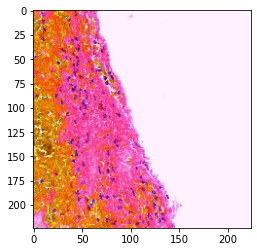

In [15]:
show_image('Good_Image_patches/10_19.png')

Good_Image_patches\10_19.png
Good_Image_patches\10_20.png
Good_Image_patches\10_21.png
Good_Image_patches\10_23.png
Good_Image_patches\10_24.png


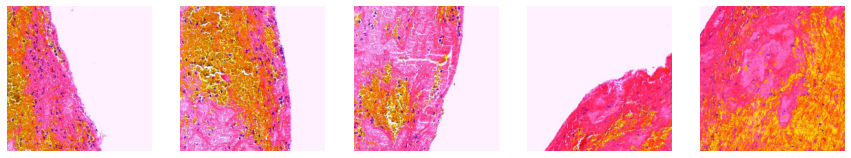

In [18]:
cardioembolic_img = tf.io.gfile.glob("Good_Image_patches/*.png")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(cardioembolic_img[:5]):
    print(filename)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    ax[idx].imshow((img.numpy()));
    ax[idx].axis('off')